In [4]:
import numpy as np
import h5py
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Masking
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [5]:
def process_h5_files(directory):
    X = []
    y = []
    for file in os.listdir(directory):
        if file.endswith(".h5"):
            filepath = os.path.join(directory, file)
            with h5py.File(filepath, "r") as f:
                # List all datasets in the file
                print(f"Datasets in {file}: {list(f.keys())}")
                
                for dataset_name in f.keys():
                    # Read the dataset (each sequence has variable length)
                    data = f[dataset_name][:]
                    label = file.split(".")[0]  # Extract label from filename
                    
                    # Append data and label
                    X.append(data)
                    y.append(label)
    
    # Return X as a list and y as a NumPy array
    return X, np.array(y)

dynamic_data_directory = 'data/dynamic'
X, y = process_h5_files(dynamic_data_directory)

# Encode labels (convert to categorical)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded)

Datasets in J.h5: ['J_0', 'J_1', 'J_10', 'J_11', 'J_12', 'J_13', 'J_14', 'J_15', 'J_16', 'J_17', 'J_18', 'J_19', 'J_2', 'J_20', 'J_21', 'J_22', 'J_3', 'J_4', 'J_5', 'J_6', 'J_7', 'J_8', 'J_9']
Datasets in Z.h5: ['Z_0', 'Z_1', 'Z_10', 'Z_11', 'Z_12', 'Z_13', 'Z_14', 'Z_15', 'Z_16', 'Z_17', 'Z_18', 'Z_19', 'Z_2', 'Z_20', 'Z_21', 'Z_22', 'Z_23', 'Z_24', 'Z_25', 'Z_3', 'Z_4', 'Z_5', 'Z_6', 'Z_7', 'Z_8', 'Z_9']


In [6]:
def pad_2d_sequences(X, max_len=None):
    # Find the maximum length if not provided
    if max_len is None:
        max_len = max([x.shape[1] for x in X])  # Use x.shape[1] since there's an extra dimension
    
    # Remove the extra dimension (1,) and pad each sequence to the maximum length
    X_squeezed = [np.squeeze(seq, axis=0) for seq in X]  # Removes the (1,) dimension
    
    X_padded = np.zeros((len(X_squeezed), max_len, X_squeezed[0].shape[1]))  # Shape (num_samples, max_len, 88)
    
    for i, seq in enumerate(X_squeezed):
        X_padded[i, :seq.shape[0], :] = seq  # Fill in the original sequence
    
    return X_padded

# Pad the sequences
X_padded = pad_2d_sequences(X)
print(X_padded.shape)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_encoded, test_size=0.4, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=4214)


(49, 60, 88)


In [7]:
# Define model using dynamic RNN (LSTM)
def create_model(input_shape, num_classes):
    # Building the Model
    model = Sequential()

   # Add a Masking layer to ignore padded values
    model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Add a Bidirectional LSTM layer for better capturing sequential patterns
    model.add(Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))

    # Add BatchNormalization for faster convergence
    model.add(BatchNormalization())

    # Add Dropout to prevent overfitting
    model.add(Dropout(0.3))

    # Add another LSTM layer
    model.add(LSTM(64, return_sequences=False))

    # Add BatchNormalization again
    model.add(BatchNormalization())

    # Add Dropout for regularization
    model.add(Dropout(0.3))

    # Fully connected layer (dense) for output classification
    model.add(Dense(64, activation='relu'))

    # Final output layer for classification (use softmax if it's a multi-class problem)
    model.add(Dense(y_train.shape[1], activation='softmax'))  # Shape of y_train must be one-hot encoded

    # Compile the model with the Adam optimizer, categorical crossentropy loss, and metrics for accuracy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [8]:
# Get the input shape from the padded data
input_shape = (X_padded.shape[1], X_padded.shape[2])  # (timesteps, features)
num_classes = y_encoded.shape[1]  # Number of output classes

In [9]:
# Create the model
model = create_model(input_shape, num_classes)

# Learning Rate Scheduler & Early Stopping to optimize training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model and include validation data
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[reduce_lr, early_stopping],
                    verbose=1)

c:\Users\horizontal\Documents\GitHub\csci218-group-project\.venv\Lib\site-packages\keras\src\layers\core\masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\horizontal\Documents\GitHub\csci218-group-project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6207 - loss: 0.8925 - val_accuracy: 1.0000 - val_loss: 0.5247 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8966 - loss: 0.3349 - val_accuracy: 1.0000 - val_loss: 0.4575 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 1.0000 - loss: 0.0624 - val_accuracy: 1.0000 - val_loss: 0.4179 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9655 - loss: 0.0940 - val_accuracy: 1.0000 - val_loss: 0.3963 - learning_rate: 0.0010
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 0.3862 - learning_rate: 0.0010
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.9000 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0216 - val_accuracy: 0.9000 - 

In [10]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 60, 88)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 256)        │       222,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 928,584 (3.54 MB)

 Trainable params: 309,314 (1.18 MB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 618,630 (2.36 MB)

In [11]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation Loss: {val_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1374
Validation Accuracy: 1.0
Validation Loss: 0.13738271594047546


In [12]:
# Save the model
model.save('relativitymatters_rnn_model.keras')

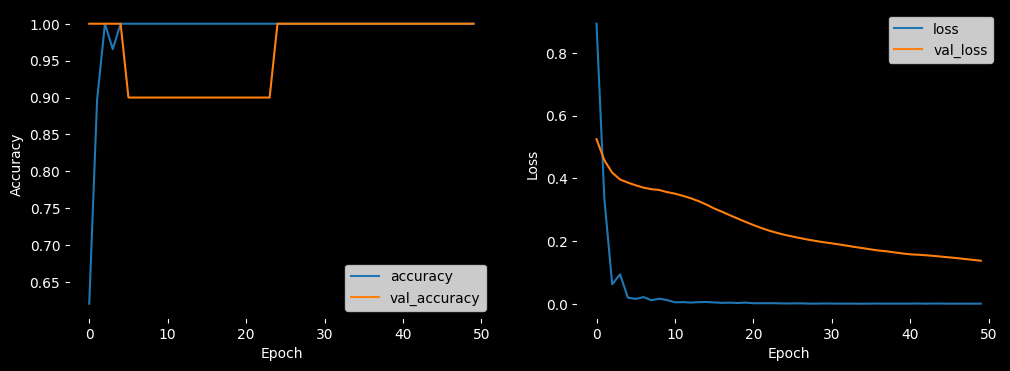

In [13]:
# Visualize training results
plt.figure(figsize=(12, 4))

# Accuracy plot
ax1 = plt.subplot(1, 2, 1)
ax1.plot(history.history['accuracy'], label='accuracy')
ax1.plot(history.history['val_accuracy'], label='val_accuracy')
ax1.set_xlabel('Epoch', color='white')
ax1.set_ylabel('Accuracy', color='white')
ax1.legend(loc='lower right')
ax1.tick_params(colors='white', which='both')
plt.setp(ax1.get_xticklabels(), color='white')
plt.setp(ax1.get_yticklabels(), color='white')
ax1.set_facecolor('black')

# Loss plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(history.history['loss'], label='loss')
ax2.plot(history.history['val_loss'], label='val_loss')
ax2.set_xlabel('Epoch', color='white')
ax2.set_ylabel('Loss', color='white')
ax2.legend(loc='upper right')
ax2.tick_params(colors='white', which='both')
plt.setp(ax2.get_xticklabels(), color='white')
plt.setp(ax2.get_yticklabels(), color='white')
ax2.set_facecolor('black')

# Set the figure background to black
plt.gcf().set_facecolor('black')

plt.show()

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_test is one-hot encoded, convert it to label format
y_test_labels = np.argmax(y_test, axis=1)

# Get the predicted labels
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, cmap='cubehelix', fmt='d', xticklabels=labels, yticklabels=labels)

# Set the plot background to black
plt.gcf().set_facecolor('black')
ax.set_facecolor('black')

# Change text color to white
ax.tick_params(colors='white', which='both')  # Change color of ticks
plt.setp(ax.get_xticklabels(), color='white')  # Change color of x-axis labels
plt.setp(ax.get_yticklabels(), color='white')  # Change color of y-axis labels
plt.title('Confusion Matrix', color='white')
plt.xlabel('Predicted Labels', color='white')
plt.ylabel('True Labels', color='white')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


NameError: name 'labels' is not defined

<Figure size 800x600 with 0 Axes>